In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import expit
import pandas as pd
from tqdm import tqdm
np.random.seed(42)

import plotly.express as px

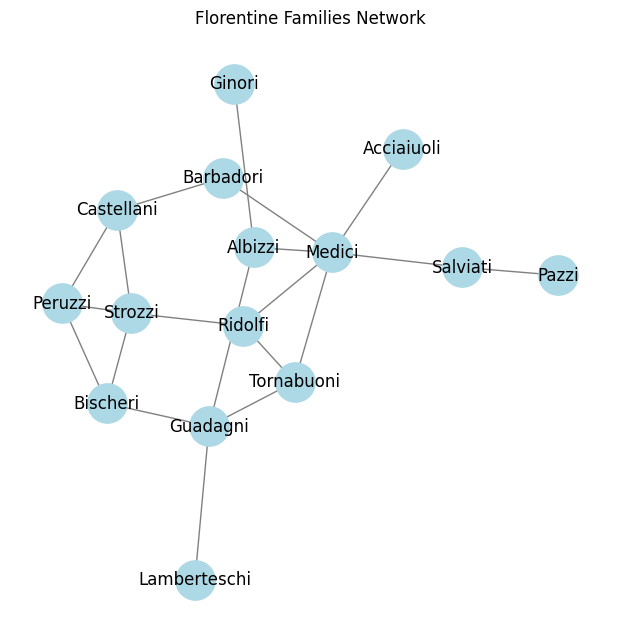

In [2]:
G = nx.florentine_families_graph()

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network")
plt.show()

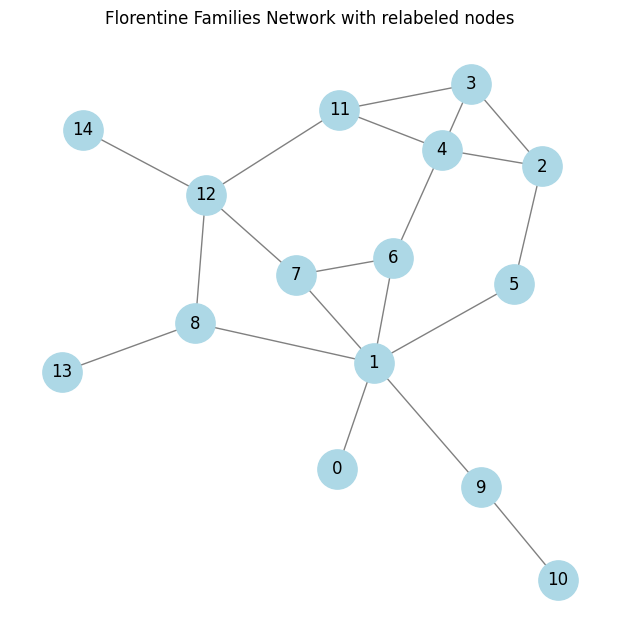

Map from original nodes to new nodes:
{'Acciaiuoli': 0, 'Medici': 1, 'Castellani': 2, 'Peruzzi': 3, 'Strozzi': 4, 'Barbadori': 5, 'Ridolfi': 6, 'Tornabuoni': 7, 'Albizzi': 8, 'Salviati': 9, 'Pazzi': 10, 'Bischeri': 11, 'Guadagni': 12, 'Ginori': 13, 'Lamberteschi': 14}


In [3]:
G = nx.florentine_families_graph()
node_mapping = {node: i for i, node in enumerate(G.nodes())}
G = nx.relabel_nodes(G, node_mapping)

plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Florentine Families Network with relabeled nodes")
plt.show()
print("Map from original nodes to new nodes:")
print(node_mapping)

[]

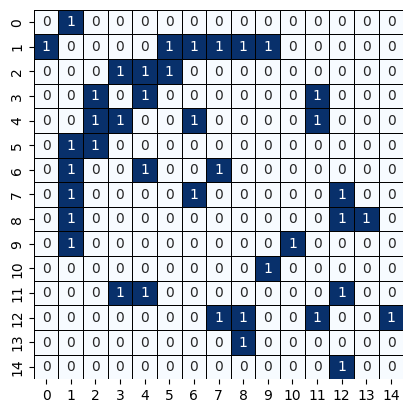

In [4]:
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=True, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='black')
plt.plot()

# Latent space

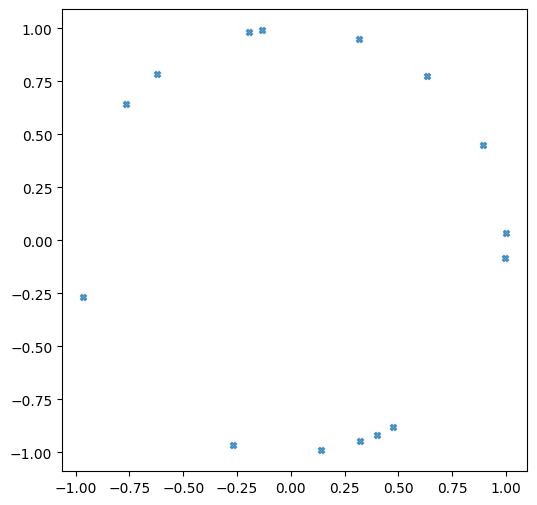

In [5]:
n = len(G.nodes)

angles = 2*np.pi*np.random.rand(n)

x = np.cos(angles)
y = np.sin(angles)
Z = np.stack((x, y), axis=1)

plt.figure(figsize=(6,6))
plt.scatter(Z[:, 0], Z[:, 1], s=20, alpha=0.7,marker="X")
plt.show()

# Likelihood

In [6]:
def loglikelihood(Z,a):
    total = 0.0
    for i in G.nodes():
        for j in G.nodes():
            d = np.arccos(np.clip(Z[i].T @ Z[j], -1.0, 1.0))/ (1*np.pi)
            eta = a * (1 - d)
            if j in G.neighbors(i):
                total += eta * 1  + (-np.logaddexp(0, eta))
            elif j != i:
                total += (-np.logaddexp(0, eta))
    return total

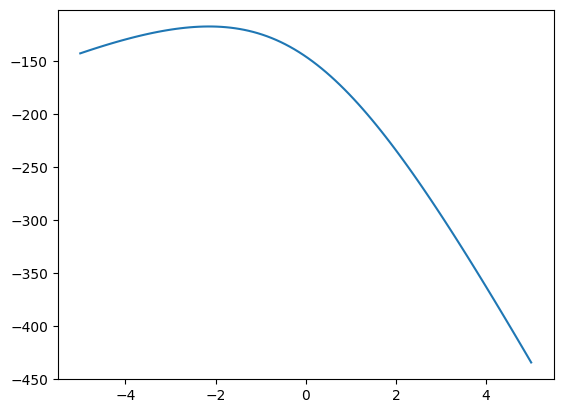

In [7]:
plt.plot(np.linspace(-5,5,100),[loglikelihood(Z,t) for t in np.linspace(-5,5,100)])
plt.show()

In [62]:
def grad_loglikelihood(Z,a):
    grad_Z = np.zeros_like(Z)
    grad_a = 0.0
    for i in G.nodes():
        for j in G.nodes():
            if j != i:
                y = 1.0 if j in G.neighbors(i) else 0.0
                dist = np.arccos(np.clip(Z[i].T @ Z[j], -1.0, 1.0))/ (1*np.pi)
                eta = a* ( 1 - dist )
                grad_Z[i,:] +=  (y-expit(eta)) * (-a) * (-1/(2*np.pi)) * Z[j] / np.sqrt(1 - (np.clip(Z[i].T @ Z[j],-0.999,0.999))**2)
                grad_a += (y-expit(eta)) * (1 - dist) 
    return grad_Z, grad_a

In [9]:
def update_Z(Z, grad_Z):
    for i in range(len(Z)):
        proj_orth = grad_Z[i]-np.dot(Z[i], grad_Z[i]) * Z[i]
        Z[i] = Z[i] + proj_orth 
        Z[i] = Z[i] / np.linalg.norm(Z[i])
    return Z

-148.56118103089497
-144.00588662645234


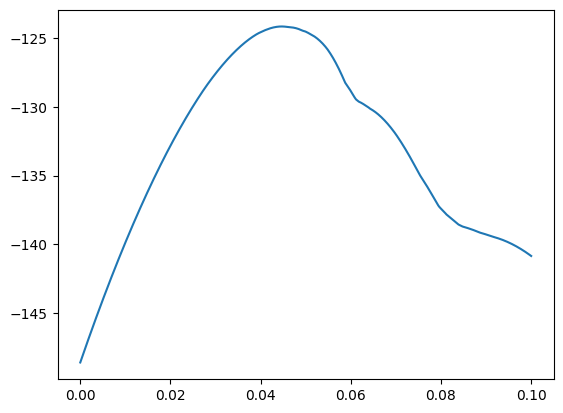

In [10]:
grad_Z,  grad_a = grad_loglikelihood(Z,0.1)
lr = 0.005
print(loglikelihood(Z,0.1))
print(loglikelihood(update_Z(Z, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[loglikelihood(update_Z(Z, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Searching MLE

In [11]:
def SearchingMLE(Z_init, a_init, tol=1e-2, max_iter=100, alpha_init=0.1, rho=0.5, c=1e-4):
    Z0 = Z_init
    historyZ = [Z0]

    a0 = a_init
    historya = [a0]
    
    for i in range(max_iter):
        grad_Z,  grad_a = grad_loglikelihood(Z0,a0)
        if np.linalg.norm(grad_Z) + np.abs(grad_a) < tol:
            break  # Convergence criterion
        
        alpha = alpha_init
        
        # Line search using the Armijo condition
        while loglikelihood(update_Z(Z0, alpha*grad_Z) ,a0 + alpha*grad_a) < loglikelihood(Z0,a0)+ c * alpha * (np.trace(np.transpose(grad_Z) @ Z0) + grad_a * a0):
            alpha *= rho
            if alpha < 1e-4:
                alpha = 0.0
                break
        
        # Update step
        Z0 = update_Z(Z0, alpha*grad_Z) 
        a0 = a0 + alpha * grad_a
        
        historyZ.append(Z0)
        historya.append(a0)
    
    return  Z0, a0, historyZ, historya

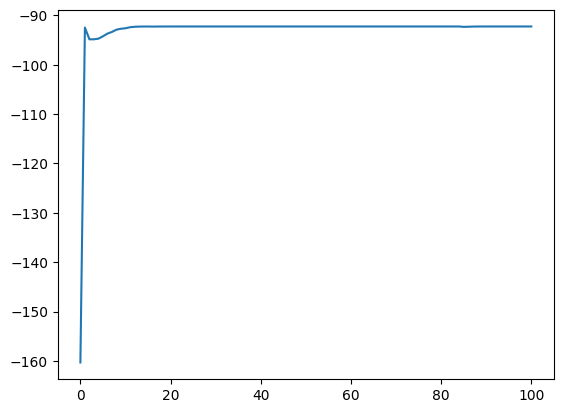

In [12]:
angles_rand = 2*np.pi*np.random.rand(n)
Z_init_MLE = np.stack((np.cos(angles_rand), np.sin(angles_rand)), axis=1)
Z0, a0, historyZ, historya  =  SearchingMLE(Z_init_MLE ,np.random.randn())
plt.plot([loglikelihood(historyZ[t],historya[t]) for t in range(len(historya))])
plt.show()

In [13]:
Z-Z0

array([[ 0.20718291,  0.47335958],
       [-0.0904595 ,  1.99006858],
       [-1.50133585,  1.11392423],
       [ 0.98303463,  0.84987931],
       [-0.76592788,  0.15588436],
       [-1.37784526,  0.64510505],
       [ 0.247647  ,  1.52060512],
       [-0.41688499,  0.00546353],
       [ 0.94782249, -0.91709523],
       [-1.25938643, -1.5456039 ],
       [ 0.87987886, -0.33246296],
       [-0.90956439,  1.2723231 ],
       [ 1.04106313,  1.039348  ],
       [ 0.24229769,  0.02755554],
       [ 0.18153405, -1.77071007]])

In [14]:
np.sum(Z0**2,axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [15]:
a0

np.float64(-3.4909073243979)

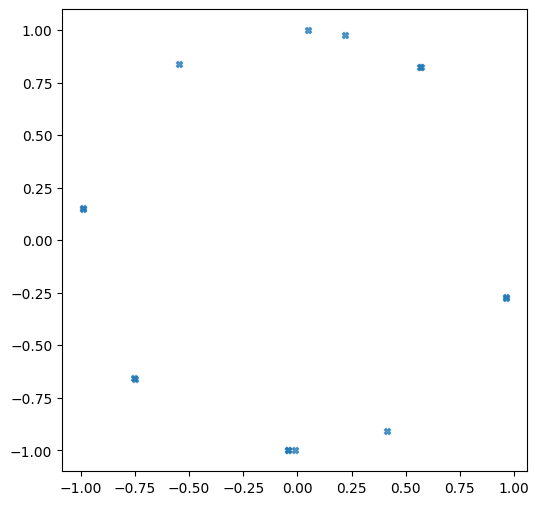

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(Z0[:, 0], Z0[:, 1], s=20, alpha=0.7,marker="X")
plt.show()

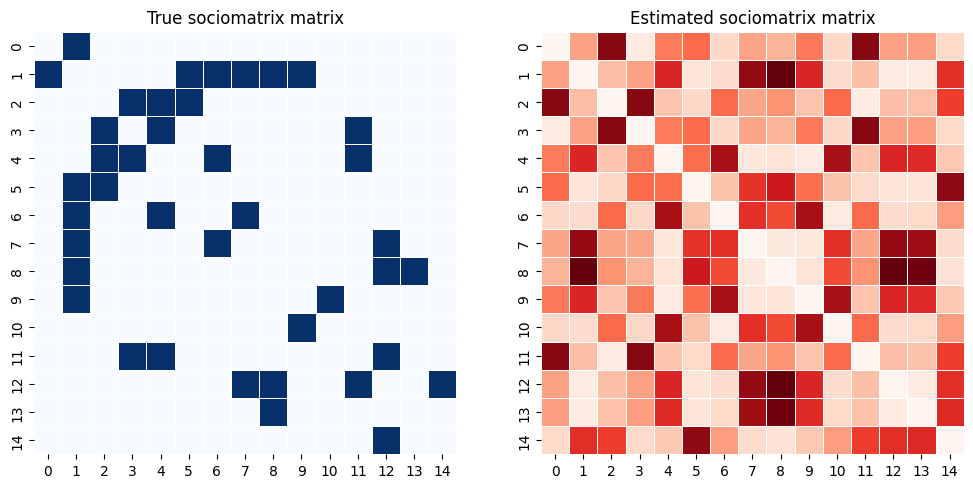

In [17]:
Y_MLE = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if j != i:
            d = np.arccos(np.clip(Z0[i].T @ Z0[j], -1.0, 1.0))/ (1*np.pi)
            Y_MLE[i,j] = expit(a0 * (1 - d))

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.heatmap(nx.to_numpy_array(G, dtype=int), annot=False, cmap="Blues", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("True sociomatrix matrix")
plt.subplot(1,2,2)
sns.heatmap(Y_MLE, annot=False, cmap="Reds", cbar=False, square=True, linewidths=0.5, linecolor='white')
plt.title("Estimated sociomatrix matrix")
plt.show()

# Prior distribution

In [63]:
def logpriori(Z,a,var=1):
    logpriorZ = 0.0
    for i in range(len(Z)):
        logpriorZ += np.log(0.1 - (Z[i].T @ Z[i] -1)**2)/10
    logpriora = 0.5 * a**2 / var
    return (-1) * (np.log((2*np.pi*var)**((n+1)/2)) + logpriorZ + logpriora)

In [64]:
logpriori(Z0,a0)

np.float64(-17.34235586555115)

In [65]:
def grad_logpriori(Z,a,var=1):
    grad_Z = np.zeros_like(Z)
    for i in G.nodes():
        grad_Z[i,:] = (4/10) * Z[i] * (Z[i].T @ Z[i] -1) / (0.1 - (Z[i].T @ Z[i] -1)**2)
    grad_a = (-1) * a / var  
    return grad_Z, grad_a

-7.800261252292627
-7.795261252292627


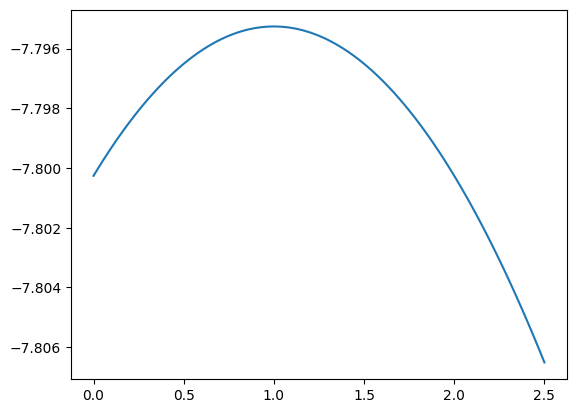

In [21]:
grad_Z,  grad_a = grad_logpriori(Z,0.1)
lr = 1.0
print(logpriori(Z,0.1))
print(logpriori(update_Z(Z, lr*grad_Z),0.1+lr*grad_a))
plt.plot(np.linspace(0.0,2.5,100),[logpriori(update_Z(Z, lr*grad_Z),0.1+lr*grad_a) for lr in np.linspace(0.0,2.5,100)])
plt.show()

# Potential Energy

In [22]:
def U(Z,a,var=1):
    return (-1) * (loglikelihood(Z,a) + logpriori(Z,a,var))

def grad_U(Z,a,var=1):
    grad_Z_likelihood, grad_a_likelihood = grad_loglikelihood(Z,a)
    grad_Z_priori, grad_a_priori = grad_logpriori(Z,a,var)
    grad_Z = grad_Z_likelihood + grad_Z_priori
    grad_a = grad_a_likelihood + grad_a_priori
    return -grad_Z, -grad_a

155.89528540292406
137.4810356232431


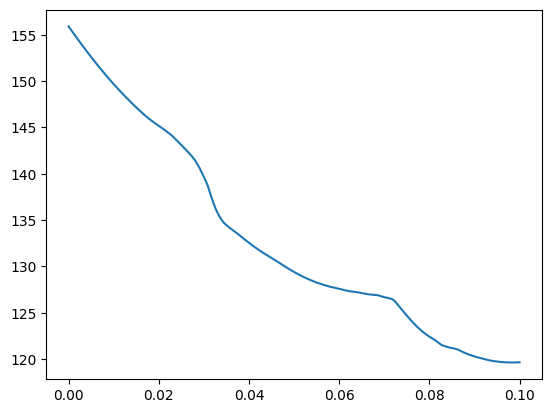

In [23]:
grad_Z,  grad_a = grad_U(Z,0.1)
lr = 0.06
print(U(Z,0.1))
print(U(update_Z(Z, -lr*grad_Z),0.1 - lr*grad_a))
plt.plot(np.linspace(0.0,0.1,1000),[U(update_Z(Z, -lr*grad_Z),0.1-lr*grad_a) for lr in np.linspace(0.0,0.1,1000)])
plt.show()

## Applying Hamiltonian Monte Carlo Algorithm

In [24]:
def project_to_tangent_space(theta, phi):
    return phi - np.dot(phi, theta) * theta

project_to_tangent_space(np.array([1.0, 0.0]), np.array([0.5, 0.1]))

array([0. , 0.1])

In [25]:
def geodesic_flow(theta, phi, step_size):
    alpha = np.linalg.norm(phi)
    if alpha > 1e-10:
        new_theta = theta * np.cos(alpha * step_size) + (phi / alpha) * np.sin(alpha * step_size)
        new_phi = phi * np.cos(alpha * step_size) - alpha * theta * np.sin(alpha * step_size)
    else:
        new_theta, new_phi = theta, phi  # Evita división por cero
    return new_theta, new_phi


geodesic_flow(np.array([1.0, 0.0]), np.array([0.5, 0.2]), step_size=1)

(array([1.33465181, 0.19047254]), array([0.15305006, 0.17169409]))

In [26]:
Z[0,:]

array([-0.53139803, -0.84712227])

In [27]:
np.arctan2(Z[:,1], Z[:,0])

array([-2.13104637,  1.72796587, -1.03793502,  1.48037255, -1.37032203,
       -3.13202724, -0.70751929, -1.35604024, -0.04374076, -1.34515488,
       -1.43266634,  1.30833948,  0.03602811, -1.30431206, -1.0135543 ])

In [28]:
Z.shape[0]

15

In [29]:
def compute_star(Old, Ref):
    ang_old = np.arctan2(Old[:,1], Old[:,0])
    ang_ref = np.arctan2(Ref[:,1], Ref[:,0])
    
    addition = np.mean(ang_ref-ang_old)
    
    ang_new = ang_old + addition
    New = np.zeros_like(Old)
    New[:,0] = np.cos(ang_new)
    New[:,1] = np.sin(ang_new)
    return New 

In [30]:
compute_star(Z,Z0)

array([[ 0.23131509, -0.97287889],
       [-0.81390894,  0.58099245],
       [ 0.97031757, -0.24183425],
       [-0.6467042 ,  0.7627409 ],
       [ 0.83829777, -0.54521266],
       [-0.69437546, -0.7196129 ],
       [ 0.99629053,  0.08605341],
       [ 0.84599863, -0.53318507],
       [ 0.73173079,  0.68159376],
       [ 0.8517523 , -0.52394467],
       [ 0.80270025, -0.59638268],
       [-0.50658766,  0.86218846],
       [ 0.67509168,  0.73773384],
       [ 0.87243541, -0.48872943],
       [ 0.97592471, -0.21810768]])

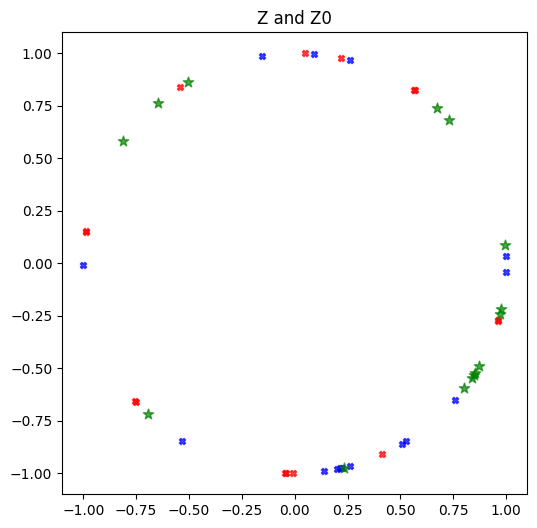

In [31]:
plt.figure(figsize=(6,6))
plt.scatter(Z[:, 0], Z[:, 1], s=20, alpha=0.7,marker="X",color="blue")
plt.scatter(Z0[:, 0], Z0[:, 1], s=20, alpha=0.7,marker="X",color="red")
plt.scatter(compute_star(Z,Z0)[:, 0], compute_star(Z,Z0)[:, 1], s=60, alpha=0.7,marker="*",color="green")
plt.title("Z and Z0")
plt.show()

In [32]:
def ghmc(Z_init, a_init, num_samples, epsilon_init=0.05, std_dev=1.0, warmup=125):
    samples_Z = [Z_init]
    samples_a = [a_init]
    Hamiltonian_p = [U(Z_init,a_init)]

    Z = Z_init.copy()
    a = a_init.copy()

    # Parámetros adaptativos
    epsilon = epsilon_init
    L = max(1, int(round(1/epsilon)))  # L = 1/ε
    accept_count = 0
    total_updates = 0

    acep_rate_history = np.zeros(num_samples)
    
    for iter in tqdm(range(num_samples)):

        # Adaptación de parámetros
        adapting = iter < warmup
        if adapting and iter > 0 and iter % 1 == 0:
            # Ajustar epsilon basado en tasa de aceptación reciente
            current_accept_rate = accept_count / total_updates if total_updates > 0 else 0
            if current_accept_rate < 0.75:
                epsilon *= 0.99  # Reducir epsilon si aceptación es baja
            elif current_accept_rate > 0.85:
                epsilon *= 1.01  # Aumentar epsilon si aceptación es alta
            L = max(1, int(round(1/epsilon)))  # Actualizar L
            accept_count = 0
            total_updates = 0



        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        ### HMC algorithm for Z

        for i in range(Z.shape[0]):
            grad_Z_i = grad_Z[i].copy()
            Z_i = Z[i].copy()
            
            p_i = np.random.normal(0, std_dev, size=Z_i.shape)
            p_i = project_to_tangent_space(Z_i, p_i)
            current_p = p_i.copy()
            #Leapfrog integration
            p_i -= epsilon * grad_Z_i / 2 
            p_i = project_to_tangent_space(Z_i, p_i)       
            for _ in range(L):
                Z_i, p_i = geodesic_flow(Z_i, p_i, epsilon)
            Z[i] = Z_i.copy()
            grad_Z,  grad_a = grad_U(Z,samples_a[-1])
            grad_Z_i = grad_Z[i].copy()
            p_i -= epsilon * grad_Z_i / 2
            p_i = project_to_tangent_space(Z_i, p_i)
            

            # Hamiltonian
            current_U = U(samples_Z[-1],samples_a[-1])
            current_K = 0.5 * np.sum(current_p**2)
            current_H = current_U + current_K
            proposed_U = U(Z,samples_a[-1])
            proposed_K = 0.5 * np.sum(p_i**2)
            proposed_H = proposed_U + proposed_K
            # Metropolis-Hastings acceptance rate
            log_accept_ratio = current_H - proposed_H
            if log_accept_ratio > 0:
                Z_C = compute_star(Z,Z0)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z_C.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            elif np.random.rand() < np.exp(log_accept_ratio):
                Z_C = compute_star(Z,Z0)
                samples_a.append(samples_a[-1])
                samples_Z.append(Z_C.copy())
                accept_count += 1
                Hamiltonian_p.append(proposed_H)
            else:
                samples_a.append(samples_a[-1])
                samples_Z.append(samples_Z[-1])
                Hamiltonian_p.append(current_H)
            total_updates += 1   

            grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])

        

        ### HMC algorithm for a
        grad_Z,  grad_a = grad_U(samples_Z[-1],samples_a[-1])


        p = np.random.normal(0, std_dev, size=1)
        current_p = p.copy()
        #Leapfrog integration
        p -= epsilon * grad_a / 2        
        for _ in range(L):
            a += epsilon * p
            grad_Z,  grad_a = grad_U(samples_Z[-1],a)
            p -= epsilon * grad_a
        p -= epsilon * grad_a / 2
        p = -p  # Negate momentum to make the proposal symmetric
        # Hamiltonian
        current_U = U(samples_Z[-1],samples_a[-1])
        current_K = 0.5 * np.sum(current_p**2)
        current_H = current_U + current_K

        proposed_U = U(samples_Z[-1],a)
        proposed_K = 0.5 * np.sum(p**2)
        proposed_H = proposed_U + proposed_K
        
        # Metropolis-Hastings acceptance rate
        log_accept_ratio = current_H - proposed_H
        if log_accept_ratio > 0:
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        elif np.random.rand() < np.exp(log_accept_ratio):
            samples_a.append(a.copy())
            samples_Z.append(samples_Z[-1])
            accept_count += 1
            Hamiltonian_p.append(proposed_H)
        else:
            samples_a.append(samples_a[-1])
            samples_Z.append(samples_Z[-1])
            Hamiltonian_p.append(current_H)
        total_updates += 1    
        acep_rate_history[iter] = accept_count / total_updates if total_updates > 0 else 0
    aceptance_rate = accept_count / total_updates
    print(f"Acceptance rate: {aceptance_rate:.5f}")
    print(f"Final parameters: epsilon={epsilon:.4f}, L={L}")
    samples_Z = np.array(samples_Z)
    samples_a = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in samples_a]
    Hamiltonian_p = [np.float64(s.item()) if isinstance(s, np.ndarray) else np.float64(s) for s in Hamiltonian_p]
    return samples_Z, samples_a, Hamiltonian_p, acep_rate_history

In [109]:
angles = 2*np.pi*np.random.rand(n)
Z1 = np.stack((np.cos(angles), np.sin(angles)), axis=1)
a1 = np.float64(0.0 + np.random.randn())

print("Log-L MLE:", loglikelihood(Z0,a0))
print("Log-L starter:", loglikelihood(Z1,a1))

Log-L MLE: -92.25844174821205
Log-L starter: -238.23655766354773


In [110]:
# Execute HMC
samples_Z, samples_a, Hp, acep_rate_history = ghmc(Z1, a1, 2500, epsilon_init=0.01, std_dev=0.2, warmup=100)

# Estimators
## CM
Z_CM =  np.mean(samples_Z, axis=0)
a_CM = np.mean(samples_a, axis=0)
## MAP
Z_MAP = samples_Z[np.argmin(Hp),:,:]
a_MAP = samples_a[np.argmin(Hp)]

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [42:49<00:00,  1.03s/it]

Acceptance rate: 0.59452
Final parameters: epsilon=0.0123, L=81


In [111]:
def plot_Z_samples_on_circle(samples_Z, num_groups=15):
    samples_Z = np.array(samples_Z)
    num_points = samples_Z.shape[1]  # Número de grupos
    palette = sns.color_palette("tab10", num_groups)

    # Convertir coordenadas cartesianas a coordenadas polares
    angles = []
    for i in range(num_points):
        trace = samples_Z[:, i, :]
        x = trace[:, 0]
        y = trace[:, 1]
        theta = np.arctan2(y, x)  # Ángulo de cada punto en el plano
        angles.append(theta)
    
    # Crear el gráfico polar
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    
    # Dibujar el histograma para cada grupo en el círculo
    for i in range(num_points):
        theta = angles[i]
        # Crear el histograma en coordenadas polares
        ax.hist(theta, bins=30, color=palette[i], alpha=0.6, label=f'{i}')

    # Agregar títulos y etiquetas
    ax.set_title("Samples on Circle (Histogram Distribution)", fontsize=16)
    ax.set_xlabel("Theta (Angle)", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.grid(True)

    # Mostrar leyenda
    ax.legend(loc="best", fontsize="small")
    
    plt.tight_layout()
    plt.show()


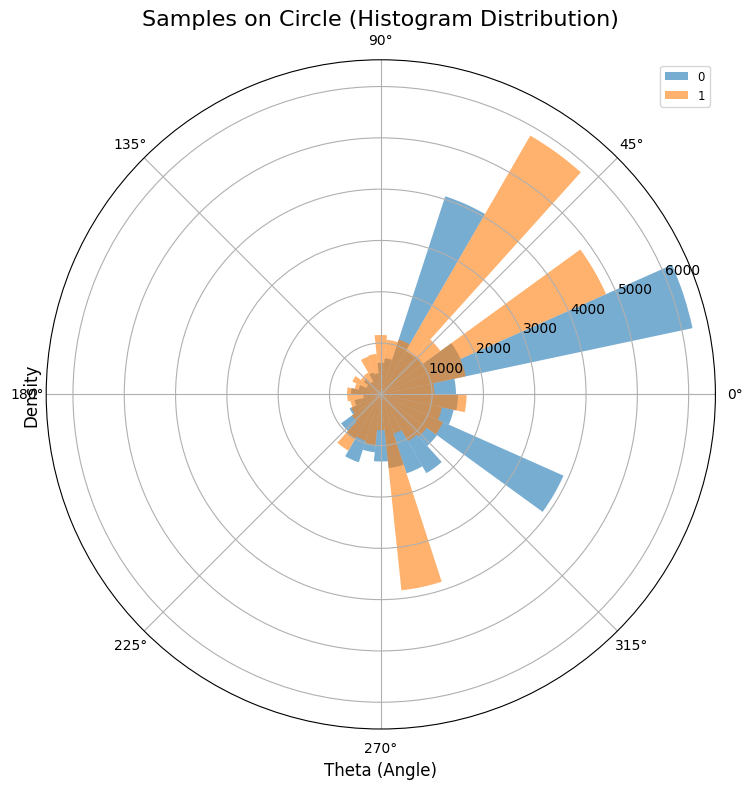

In [112]:
plot_Z_samples_on_circle(samples_Z[:,12:14,:],2)

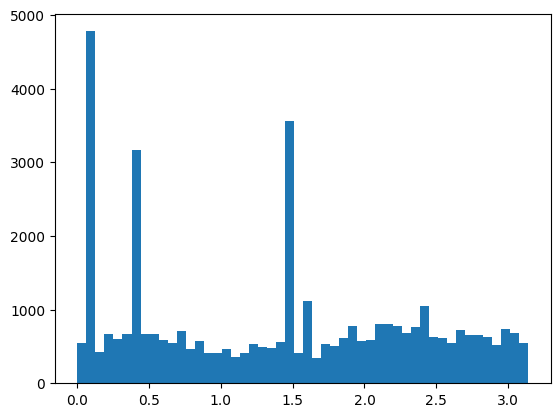

In [113]:
plt.hist(np.mod(np.arctan2(samples_Z[:,11,1],samples_Z[:,11,0]),np.pi),bins = 50)
plt.show()

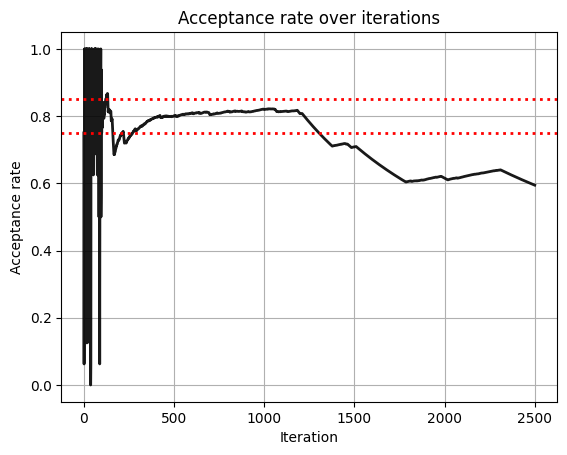

In [114]:
plt.plot(acep_rate_history, color='black', alpha=0.9, linewidth=2)
plt.axhline(0.85, color='red', linestyle=':', linewidth=2, label='')
plt.axhline(0.75, color='red', linestyle=':', linewidth=2)
plt.xlabel("Iteration")
plt.ylabel("Acceptance rate")
plt.title("Acceptance rate over iterations")
plt.grid(True)
plt.show()

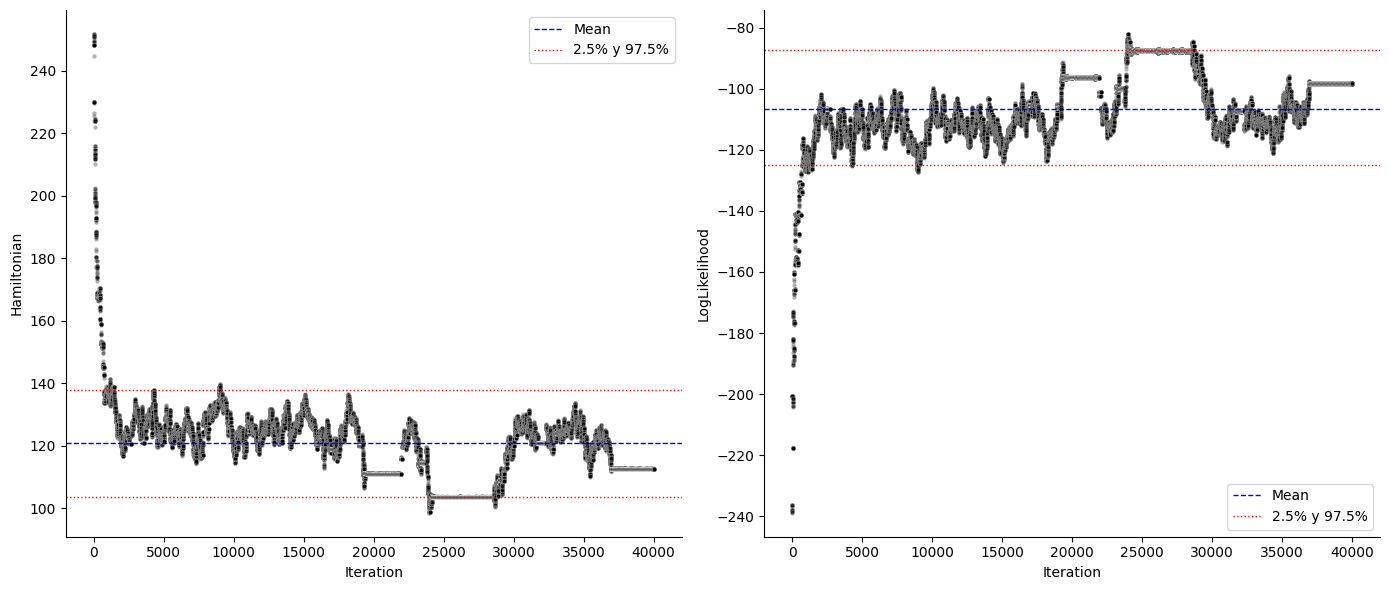

In [115]:
# 
x1 = Hp
iterations1 = np.arange(1, len(x1) + 1)
data1 = pd.DataFrame({
    'Iteration': iterations1,
    'LogLikelihood': x1
})
mean1 = np.mean(x1)
quantiles1 = np.quantile(x1, [0.025, 0.975])

# 
x2 = [np.float64(loglikelihood(samples_Z[i],samples_a[i]))for i in range(1,len(samples_a))]
iterations2 = np.arange(1, len(x2) + 1)
data2 = pd.DataFrame({
    'Iteration': iterations2,
    'LogLikelihood': x2
})
mean2 = np.mean(x2)
quantiles2 = np.quantile(x2, [0.025, 0.975])

#
fig, axs = plt.subplots(1, 2, figsize=(14, 6))  # 1 fila, 2 columnas

# 
sns.scatterplot(ax=axs[0], x='Iteration', y='LogLikelihood', data=data1, color='black', alpha=0.3, s=10)
axs[0].axhline(mean1, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[0].axhline(quantiles1[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[0].axhline(quantiles1[1], color='red', linestyle=':', linewidth=1)
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Hamiltonian")
axs[0].legend()


#
sns.scatterplot(ax=axs[1], x='Iteration', y='LogLikelihood', data=data2, color='black', alpha=0.3, s=10)
axs[1].axhline(mean2, color='blue', linestyle='--', linewidth=1, label='Mean')
axs[1].axhline(quantiles2[0], color='red', linestyle=':', linewidth=1, label='2.5% y 97.5%')
axs[1].axhline(quantiles2[1], color='red', linestyle=':', linewidth=1)
axs[1].set_xlabel("Iteration")
axs[1].set_ylabel("LogLikelihood")
axs[1].legend()

sns.despine()
plt.tight_layout()
plt.show()
